# Level 1 VQ-VAE Run Script

## Import a bunch of libraries

In [1]:
import IPython

import torch
from torch.utils.data import DataLoader
import yaml
import matplotlib.pyplot as plt
import torchaudio

from models.multi_level_vqvae_new import MultiLvlVQVariationalAutoEncoder
from models.transformer_vqvae import TransformerVQVAE
from loaders.music_loader import MP3SliceDataset
from utils.other import load_cfg_dict

## Load configuration file and add the weights path

In [2]:
config_path = "config/lvl1_config_new.yaml"
#weights_path = "model_weights/lvl1_vqvae.ckpt"
weights_path = "model_best.ckpt"
cfg = load_cfg_dict(config_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define Mel Spectrogram, and other spectrograms

In [3]:
n_mels = 256
mel_spec_new = torchaudio.transforms.MelSpectrogram(n_fft=2048, hop_length=128, n_mels=n_mels, f_min=20,
                                                    pad_mode='reflect', power=1.0, norm= "slaney", mel_scale= "htk").to(device)


## Load the model

In [4]:
model = MultiLvlVQVariationalAutoEncoder(**cfg)
model = model.load_from_checkpoint(weights_path, **cfg, strict=False).to(device=device)
model.eval()

TransformerVQVAE(
  (encoder): TransEncoder(
    (attn_stack): ModuleList(
      (0): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.0, inplace=False)
            (dropout2): Dropout(p=0.0, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=T

In [5]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/mp3" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

## Load a dataset sample and display it

## Create a weight matrix

In [6]:
lin_vector = torch.linspace(0.5, 2, n_mels)
eye_mat = torch.diag(lin_vector).to(device)

Loading file data/music_samples/000-datatensor.pt...
Music file data/music_samples/000-datatensor.pt is loaded.
Loading file data/music_samples/000-metadata.pkl...
Music file data/music_samples/000-metadata.pkl is loaded.
Current track is data/music_samples/01 Infected Mushroom - Bust A Move (Bliss Remix).mp3


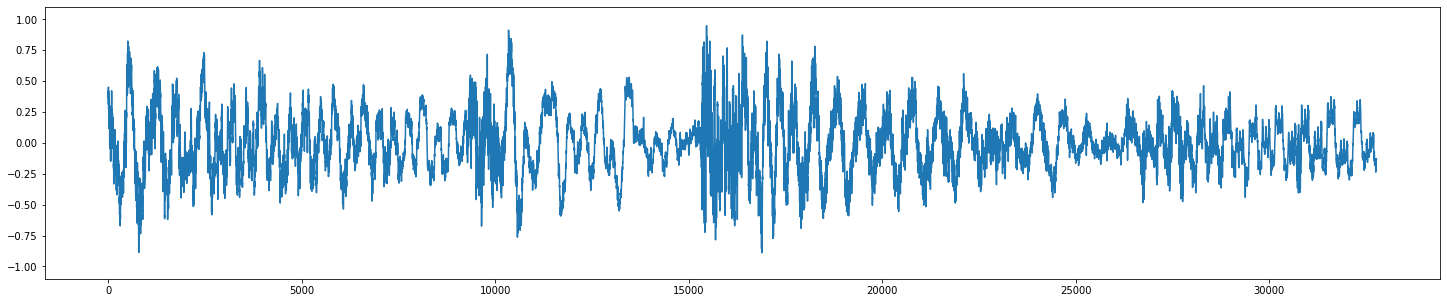

In [7]:
dataset = MP3SliceDataset(preload=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for sample in dataloader:
    music_sample = sample['music slice'].squeeze(0)
    print(f"Current track is {sample['track name'][0]}")
    break
plt.figure(figsize=(25, 5))
plt.plot(music_sample[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample.mp3', music_sample.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample.mp3")

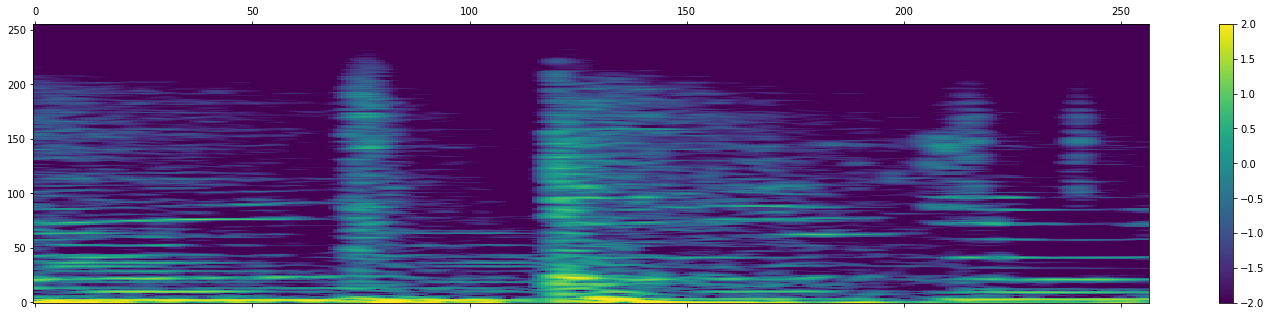

In [8]:
mel_spec = mel_spec_new(music_sample[0, ...].to(device))
plt.figure(figsize=(25, 5))
plt.matshow(torch.log(eye_mat @ mel_spec).cpu().detach().numpy(), origin='lower', fignum=1, aspect='auto', vmin=-2, vmax=2)
plt.colorbar()
plt.show()

## Run the dataset sample through the Lvl1VQVAE

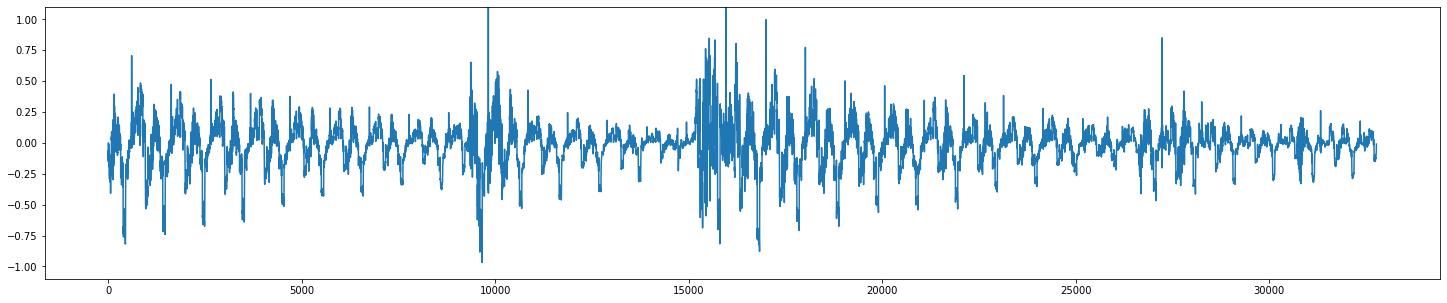

In [9]:
music_sample = music_sample.to(device)
output = model(music_sample.unsqueeze(0))
music_sample_rec = output['output'][0]
plt.figure(figsize=(25, 5))
plt.plot(music_sample_rec[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_rec.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

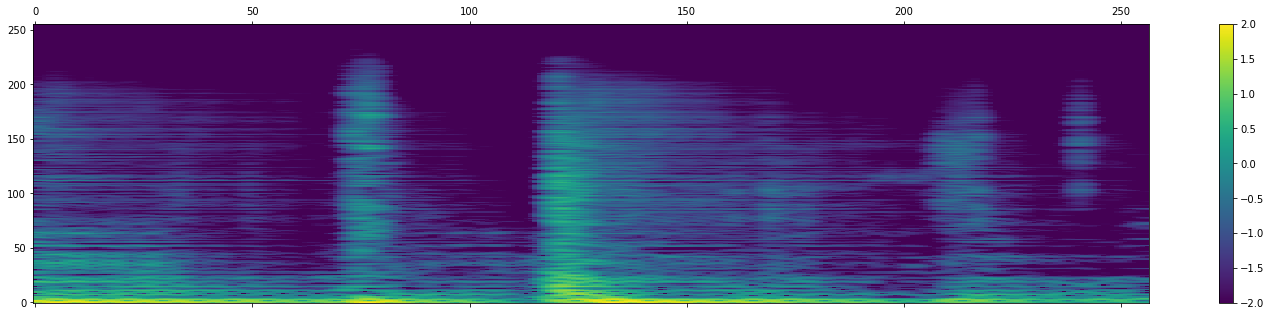

In [10]:
mel_spec = mel_spec_new(music_sample_rec[0, ...])
plt.figure(figsize=(25, 5))
plt.matshow(torch.log(eye_mat @ mel_spec).cpu().detach().numpy(), origin='lower', fignum=1, aspect='auto', vmin=-2, vmax=2)
plt.colorbar()
plt.show()

# Denoiser

## Load model

In [11]:
from models.unet_denoiser import WaveUNet_Denoiser

weights_path = 'model_weights/denoiser.ckpt'
cfg_path = 'config/denoiser_config.yaml'
with open(cfg_path, 'r') as f:
    cfg_dict = yaml.safe_load(f)
cfg_den = {**cfg_dict['model'], **cfg_dict['learning']}
denoiser = WaveUNet_Denoiser(**cfg_den).to(device=device)
# denoiser = denoiser.load_from_checkpoint(weights_path, **cfg_den, strict=False).to(device=device)
denoiser.eval()

WaveUNet_Denoiser(
  (encoder): ModuleList(
    (0): Conv1d(1, 32, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
    (2): Conv1d(64, 96, kernel_size=(15,), stride=(1,), padding=(7,))
    (3): Conv1d(96, 128, kernel_size=(15,), stride=(1,), padding=(7,))
    (4): Conv1d(128, 160, kernel_size=(15,), stride=(1,), padding=(7,))
    (5): Conv1d(160, 192, kernel_size=(15,), stride=(1,), padding=(7,))
    (6): Conv1d(192, 224, kernel_size=(15,), stride=(1,), padding=(7,))
    (7): Conv1d(224, 256, kernel_size=(15,), stride=(1,), padding=(7,))
    (8): Conv1d(256, 288, kernel_size=(15,), stride=(1,), padding=(7,))
    (9): Conv1d(288, 320, kernel_size=(15,), stride=(1,), padding=(7,))
  )
  (decoder): ModuleList(
    (0): Conv1d(640, 320, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(608, 288, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): Conv1d(544, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  

## Run the sample through the denoiser

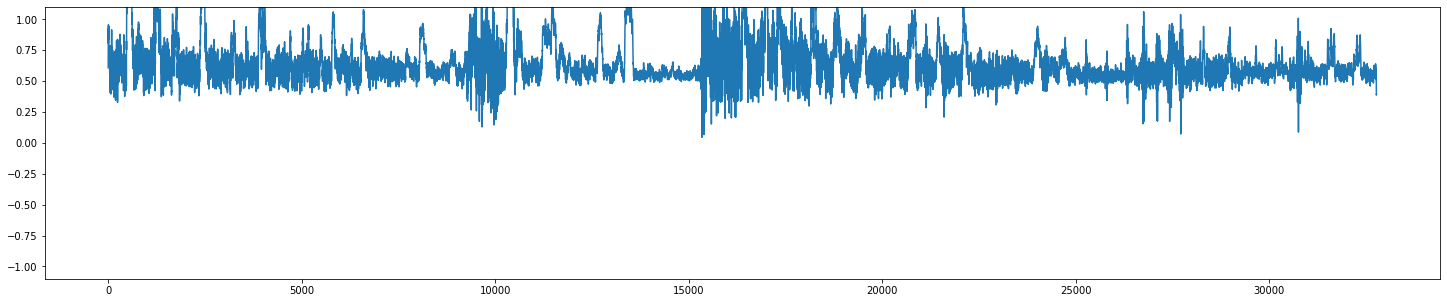

In [12]:
music_sample_den = denoiser(music_sample.unsqueeze(0))['output'].squeeze(0)
plt.figure(figsize=(25, 5))
plt.plot(music_sample_den[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_den.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

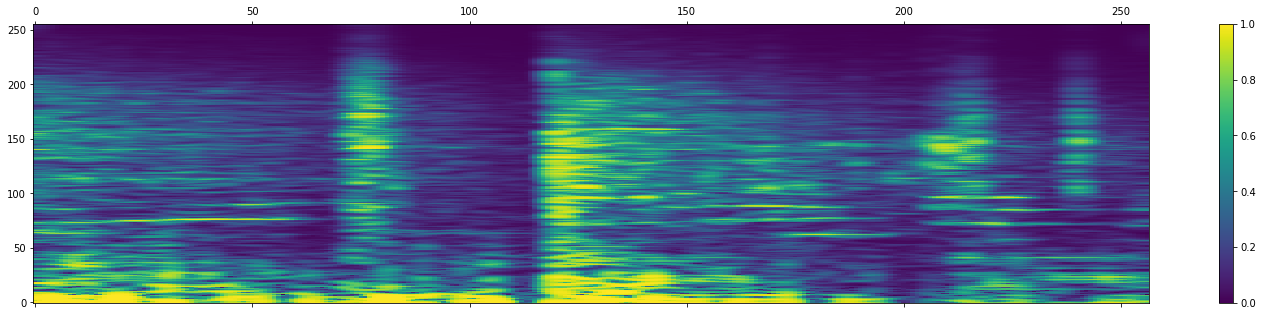

In [13]:
mel_spec = mel_spec_new(music_sample_den[0, ...])
plt.figure(figsize=(25, 5))
plt.matshow(torch.tanh(eye_mat @ mel_spec).cpu().detach().numpy(), origin='lower', fignum=1, aspect='auto', vmin=0, vmax=1)
plt.colorbar()
plt.show()

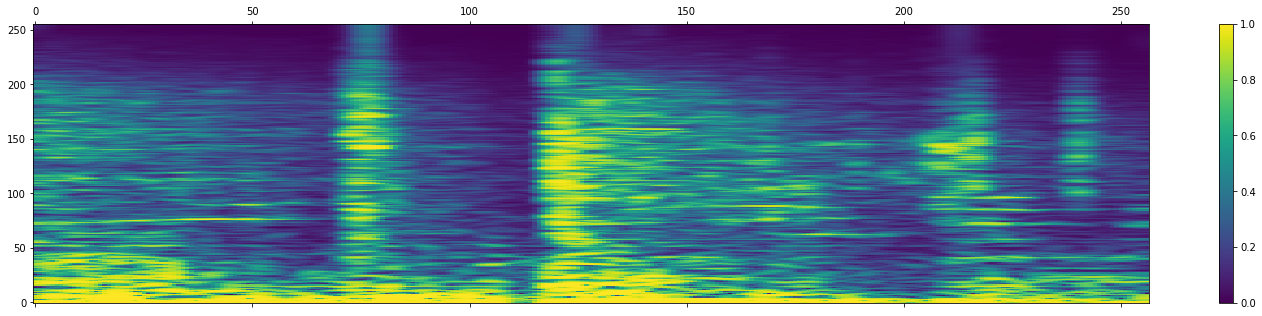

In [14]:
mel_spec = mel_spec_new(torch.abs(music_sample_rec[0, ...] - music_sample_den[0, ...]))
plt.figure(figsize=(25, 5))
plt.matshow(torch.tanh(eye_mat @ mel_spec).cpu().detach().numpy(), origin='lower', fignum=1, aspect='auto', vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Diffusion Denoiser

## Load model

In [15]:
from models.diffusion_vit import DiffusionViT

weights_path = 'model_weights/denoiser_diff.ckpt'
cfg_path = 'config/denoiser_diff_config.yaml'
with open(cfg_path, "r") as f:
    cfg_dict = yaml.safe_load(f)
cfg_den = {**cfg_dict['model'], **cfg_dict['learning']}
denoiser = DiffusionViT(**cfg_den)
denoiser = denoiser.load_from_checkpoint(weights_path, **cfg_den, strict=False).to(device=device).eval()
denoiser.eval()

DiffusionViT(
  (fc_in): Linear(in_features=32, out_features=512, bias=True)
  (transformer_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.0, inplace=False)
    (dropout2): Dropout(p=0.0, inplace=False)
    (dropout3): Dropout(p=0.0, inplace=False)
  )
  (transformer): TransformerDecoder(
    (layers): ModuleList(
   

## Run a sample through the denoiser

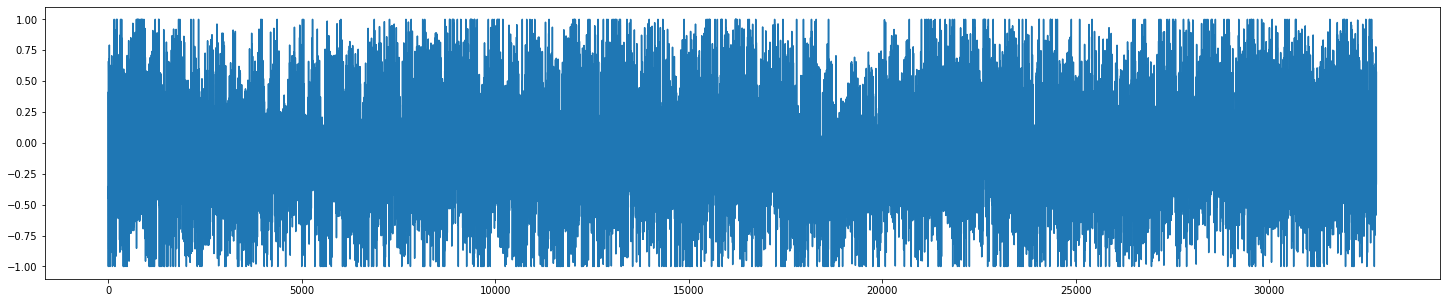

In [16]:
random_noise_start = torch.randn_like(music_sample_rec.unsqueeze(0))
music_sample_den = denoiser.denoise(music_sample_rec.unsqueeze(0).to(device), show_process_plots=False).squeeze(0)
plt.figure(figsize=(25, 5))
plt.plot(music_sample_den[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_den.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

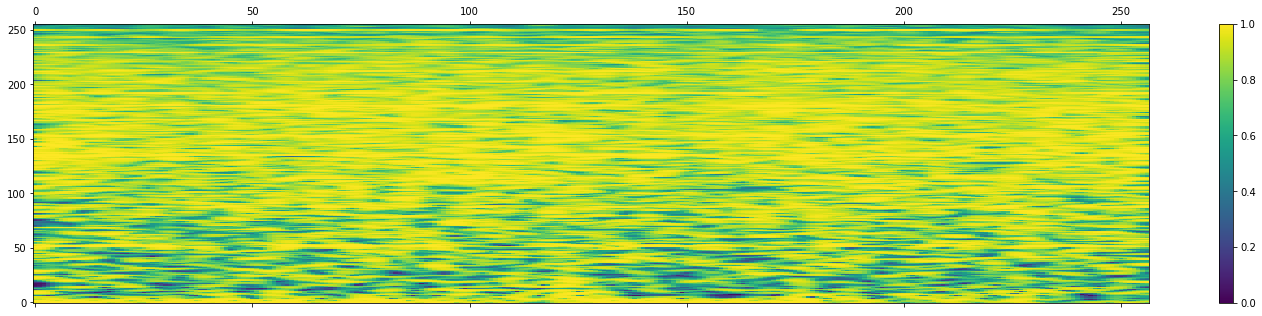

: 

In [17]:
mel_spec = mel_spec_new(music_sample_den[0, ...])
plt.figure(figsize=(25, 5))
plt.matshow(torch.tanh(eye_mat @ mel_spec).cpu().detach().numpy(), origin='lower', fignum=1, aspect='auto', vmin=0, vmax=1)
plt.colorbar()
plt.show()